## 彼得林奇PEG价值选股策略

### 1. 导语

彼得·林奇（Peter Lynch）生于1944年1月19日, 是一位卓越的股票投资家和证券投资基金经理, 曾被《时代杂志》评为首席基金经理。1977年至1990年, 在彼得·林奇管理麦哲伦基金的13年间, 基金规模大幅扩增, 由2000万美元成长至140亿美元！他对共同基金的贡献，就像是乔丹之于篮球，邓肯之于现代舞蹈。他不是人们日常认识中的那种脑满肥肠的商人，他把整个比赛提升到一个新的境界，他让投资变成了一种艺术。

彼得·林奇一直以他的选股能力而著称，他有一句名言：只要用心对股票做一点点研究，普通投资者也能成为股票投资专家，并且在选股方面的成绩能像华尔街的专家一样出色。下面将介绍一下彼得·林奇推广的“PEG价值选股法”。

### 2. 策略思路

#### 每个调仓日：


1. 设置所有A股为股票池, 获取股票的市盈率(PE_ttm)和单季度的净利润增长率(growth_rate)
2. 选择PEG < 0.5, 即稳定成长且价值被低估的股票, 其中PEG = PE_ttm / growth_rate
3. 使用ES风险平价配权(即每只股票对组合的ES风险度量相等)
4. 根据组合的日内波动小于3%的条件, 与货币基金组合配资
5. 最大持仓5只股票和1只货币基金, 优先买入市值小的, 15天调仓一次
6. 剔除了周期性和项目类行业(该部分对改善回撤有明显的效果)
7. 根据选股情况进行调仓

**无止盈止损条件**

## 3. 代码示意图

![index.png](attachment://index.png)
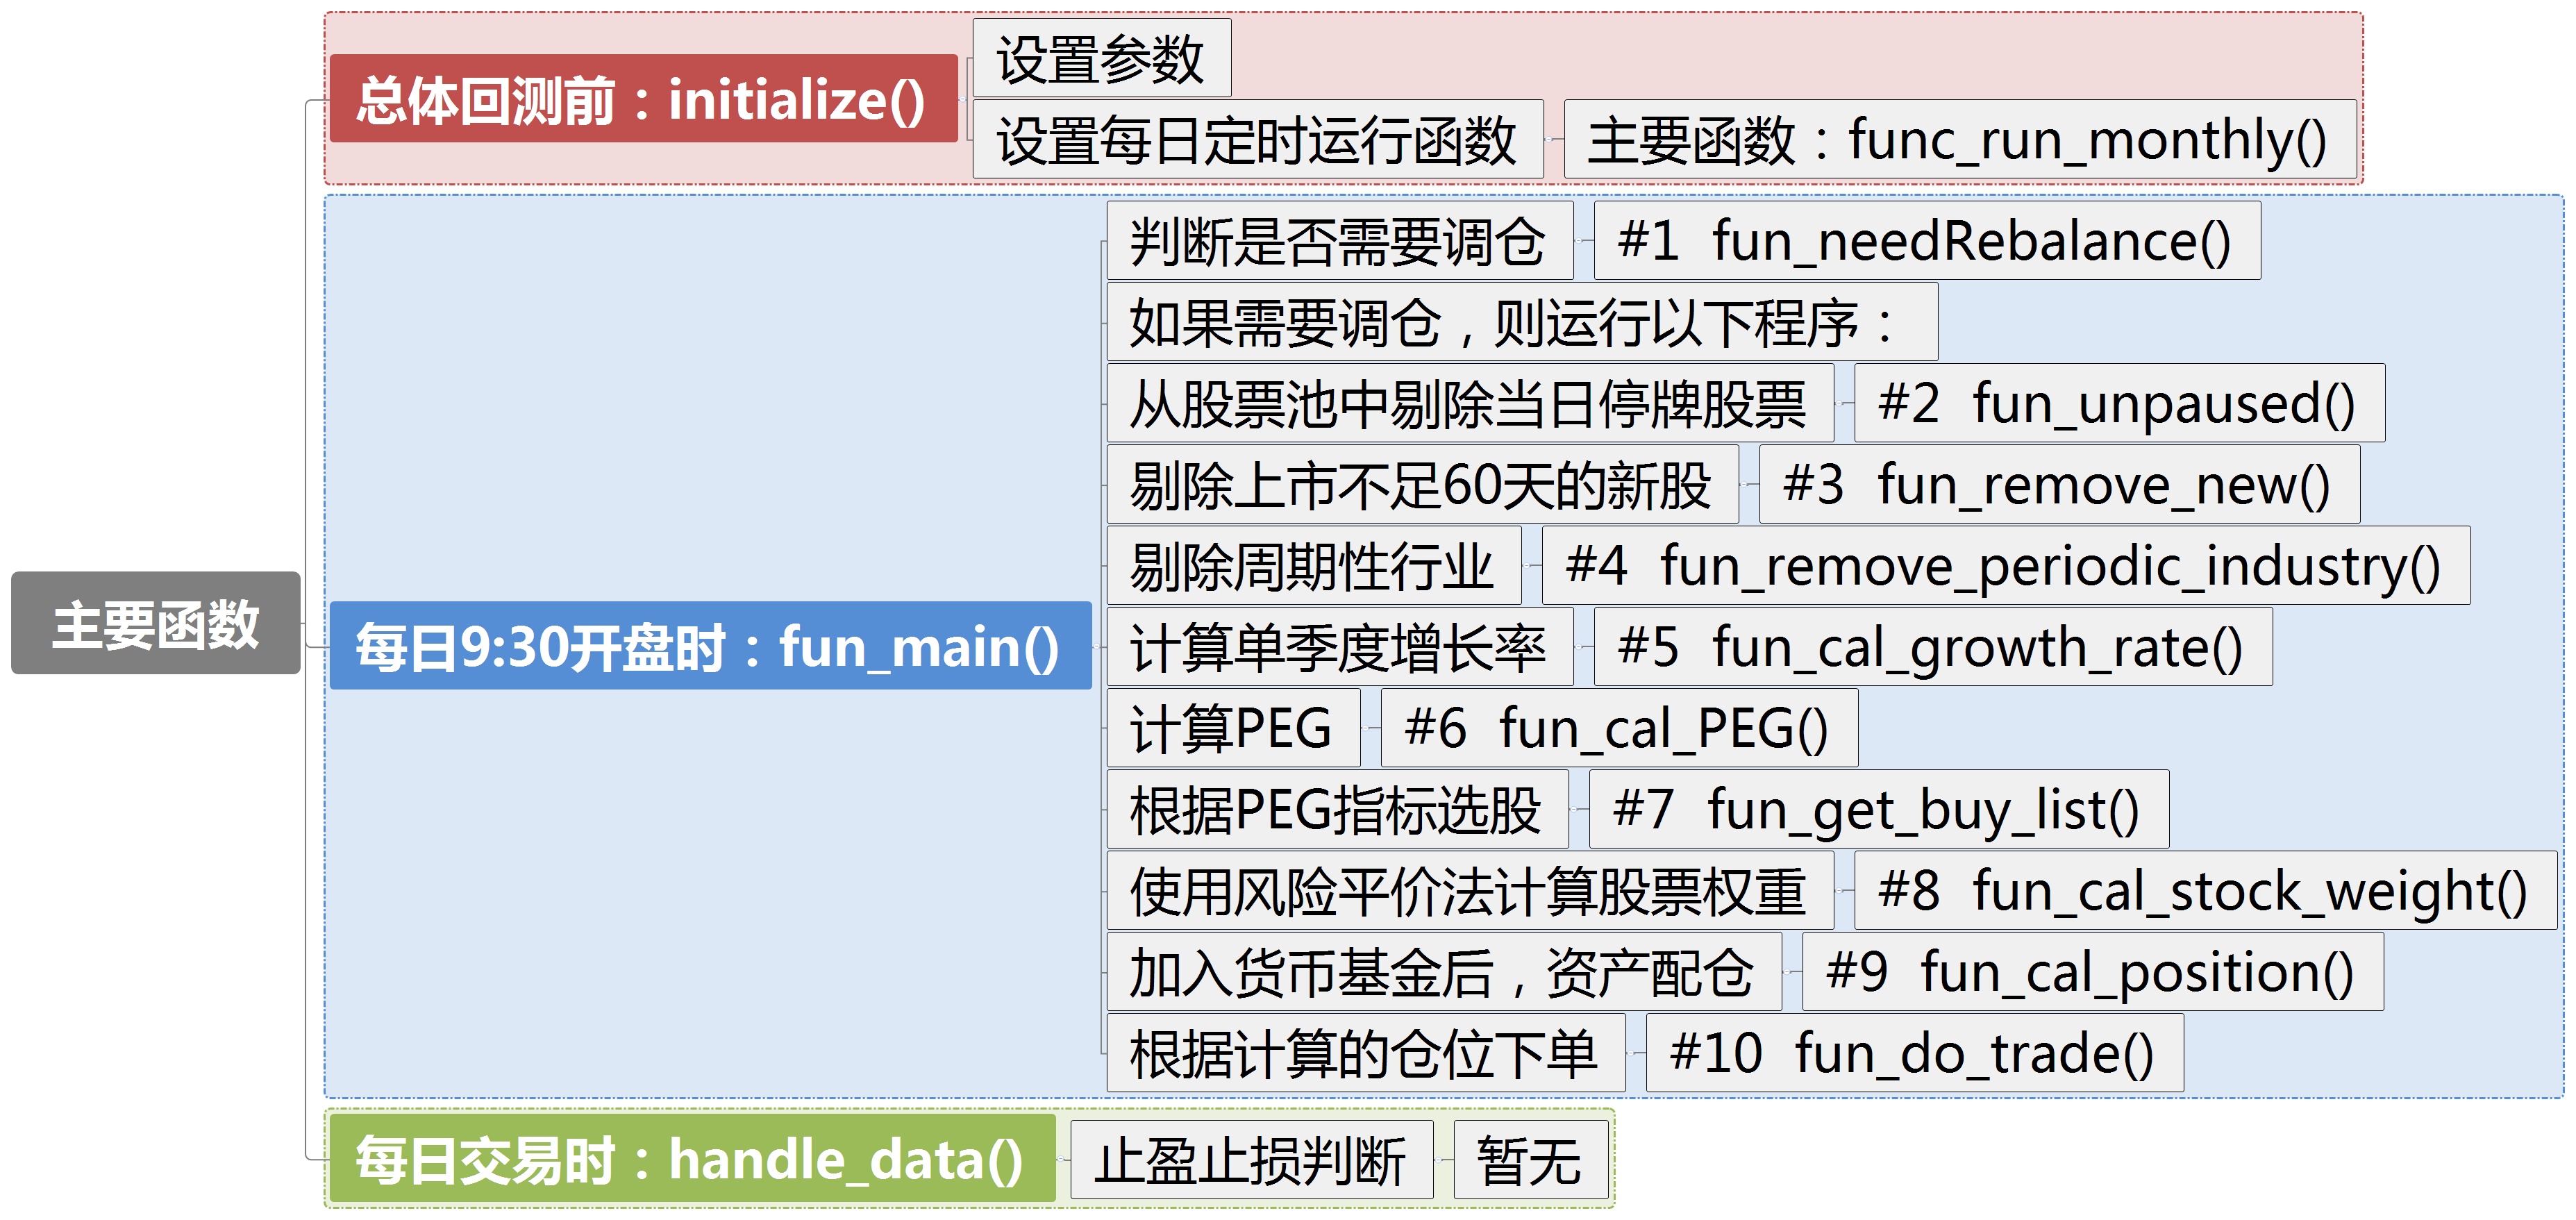

In [ ]:
'''
策略名称: 彼得林奇PEG价值选股策略

策略思路:
1.选择PEG < 0.5, 即稳定成长且价值被低估的股票
  其中PEG = PE / growth_rate
2.使用ES风险平价配权
3.根据组合的日内波动小于3%的条件, 与货币基金组合配资
4.最大持仓5只股票和1只货币基金, 优先买入市值小的, 15天调仓一次
5.剔除了周期性和项目类行业(该部分对改善回撤有明显的效果)
'''

import pandas as pd
import numpy as np
import datetime as dt

def initialize(account):
    # 当前持仓数：0
    account.num = 0
    # 最大持仓股票数：5
    account.stock_max_num = 5
    
    # 每只股票的最大风险敞口
    account.risk_limit = 0.03 / account.stock_max_num
    
    # 已持仓天数：0天
    # 持仓周期：15天
    account.hold_days, account.hold_cycle = 0, 15
    
    # 计算ES的置信度
    account.confidenceLevel = 0.05
    # 计算ES的历史回测长度
    account.lag = 180
    
    # 每个交易日09:31运行
    run_daily(func=fun_main, reference_security='000300.SH')

    
######################  主函数 
def fun_main(account, data):
    flag = fun_needRebalance(account)
    
    if flag:
        last_date = get_last_datetime().strftime('%Y%m%d')
        universe = list(get_all_securities('stock', date = last_date).index)
        # stock_list = universe
        stock_list = fun_unpaused(data, universe)
        stock_list = fun_remove_new(stock_list, 60)
        stock_list = fun_remove_periodic_industry(stock_list, last_date)
        

        line = '###############' + str(last_date) + ': ' + str(len(universe)) + ' / ' + str(len(stock_list))
        print(line)

        # 计算单季度增长率
        df_growth = fun_cal_growth_rate(data, stock_list, last_date)

        # 计算PEG
        df_all = fun_cal_PEG(data, df_growth.copy(), last_date)

        # 选股
        buy_list = fun_get_buy_list(account, data, df_all.copy(), account.stock_max_num, last_date)

        # 计算股票权重
        stock_weight = fun_cal_stock_weight(buy_list, account.lag, account.confidenceLevel, last_date, 'ES')
        print('stock_weight: ')
        print(stock_weight)
        
        bond_weight = {'511880.OF': 1.0}
        
        # 计算最终权重（考虑组合风险 + 债券）
        trade_ratio = fun_cal_position(account, data, stock_weight, bond_weight)
        
        print('trade_ratio: ')
        print(trade_ratio)
        
        # 下单
        fun_do_trade(account, data, trade_ratio)

    account.num = len(account.positions)


def handle_data(account,data):
    pass


#### 1.判断是否调仓函数 #########################################
def fun_needRebalance(account):
    # 条件1: 持仓股数为0时，重新调仓
    if account.num == 0:
        account.hold_days = 0
        return True
    
    # 条件2：持仓到调仓周期时，重新调仓
    elif account.hold_days == account.hold_cycle:
        account.hold_days = 0
        return True
    
    else:
        account.hold_days += 1
        return False


#### 2.剔除停牌股票函数 #########################################
def fun_unpaused(data, _stock_list):
    values = data.current(_stock_list)
    return [s for s in _stock_list if not values[s].is_paused] 
    

#### 3.剔除上市不到60天的新股 ###################################
def fun_remove_new(_stock_list, days):
    
    deltaDate = get_datetime() - dt.timedelta(days)
    
    stock_list = []
    for stock in _stock_list:
        if get_security_info(stock).start_date < deltaDate:
            stock_list.append(stock)
    
    return stock_list
    

#### 4.剔除周期性行业 ###########################################
def fun_remove_periodic_industry(stock_list, last_date):
    
    periodic_industry = [#'T0101', # 种植业与林业
                         #'T0102', # 养殖业
                         #'T0103', # 农产品加工
                         #'T0104', # 农业服务
        
                         'T0201', # 煤炭开采
                         'T0202', # 石油矿业开采
                         'T0203', # 采掘服务
                         'T0301', # 基础化学
                         'T0302', # 化学制品
                         'T0303', # 化工新材料
                         'T0304', # 化工合成材料
                         'T0401', # 钢铁
                         'T0501', # 有色冶炼加工
                         'T0502', # 新材料
        
                         'T0601', # 建筑材料
                         'T0602', # 建筑装饰
                         'T0701', # 通用设备
                         'T0702', # 专用设备
                         'T0703', # 仪器仪表
                         'T0704', # 电气设备
                         #'T0801', # 半导体及元件
                         #'T0802', # 光学光电子
                         #'T0803', # 其他电子
                         #'T0804', # 电子制造
                         'T0901', # 汽车整车
                         'T0902', # 汽车零部件
                         'T0903', # 非汽车交运
                         'T0904', # 交运设备服务
                         #'T1001', # 通信设备
                         #'T1002', # 计算机设备
                         'T1101', # 白色家电
                         'T1102', # 视听器材
                         #'T1201', # 饮料制造
                         #'T1202', # 食品加工制造
                         #'T1301', # 防止制造
                         #'T1302', # 服装家纺
                         #'T1401', # 造纸
                         #'T1402', # 包装印刷
                         #'T1403', # 家用轻工
                         #'T1501', # 化学制药
                         #'T1502', # 中药
                         #'T1503', # 生物制品
                         #'T1504', # 医药商业
                         #'T1505', # 医疗器械服务
                         'T1601', # 电力
                         'T1602', # 燃气水务
                         'T1603', # 环保工程
                         'T1701', # 港口航运
                         'T1702', # 公路铁路运输
                         #'T1703', # 公交
                         #'T1704', # 机场航运
                         #'T1705', # 物流
                         'T1801', # 房地产开发
                         'T1802', # 园区开发
        
                         'T1901', # 银行
                         'T1902', # 保险及其他
                         'T1903', # 证券
                         #'T2001', # 零售
                         'T2002', # 贸易
                         #'T2101', # 景点及旅游
                         #'T2102', # 酒店及餐饮
                         #'T2201', # 通信服务
                         #'T2202', # 计算机应用
                         #'T2203', # 传媒
                         #'T2301', # 综合
                         #'T2401'  # 国防军工
                         ]
    
    for industry in periodic_industry:
        stocks = get_industry_stocks(industry, last_date)
        stock_list = list(set(stock_list).difference(set(stocks)))
    
    return stock_list


#### 5.计算单季度增长率函数 ####################################################
def fun_cal_growth_rate(data, stock_list, last_date):
    
    # 计算单季度净收益函数
    def fun_get_quarterly_net_profit(current_quarter, last_quarter, stock_list):
        q = query(income.symbol,
                  income.net_profit
                 ).filter(income.symbol.in_(stock_list))

        # 当季度累计净利润
        df1 = get_fundamentals(q, statDate = current_quarter)
        df1.columns = ['symbol', 'total_net_profit']

        # 上季度累计净利润
        df2 = get_fundamentals(q, statDate = last_quarter)
        df2.columns = ['symbol', 'last_total_net_profit']

        df = pd.merge(df1, df2, on='symbol')

        # 当前单季度净利润
        df['quarterly_net_profit'] = df['total_net_profit'] - df['last_total_net_profit']

        del df['total_net_profit']
        del df['last_total_net_profit']

        return df
    
    ########## 获取财报季度日期 
    q = query(income.symbol, 
              income.stat_date
             ).filter(income.symbol.in_(stock_list))

    df = get_fundamentals(q, date = last_date)
    
    df = df.sort_values(['income_stat_date'], ascending=False)
    
    last_statDate = df.iloc[0,1]
    
    # 剔除未按时公布报表的公司，避免未来函数
    df[df['income_stat_date'] != last_statDate] = None
    df = df.dropna()
    stock_list = list(df['income_symbol'].values)

    the_year = int(str(last_statDate)[0:4])
    the_month = str(last_statDate)[5:7]

    ########## 获取财报单季度净利润增长率
    '''
    quarter_1:  当季度
    quarter_2:  上季度
    quarter_3:  同比上季度
    quarter_4:  去年上季度
    '''

    if the_month == '03':
        # 因为一季度的报表是单季度表，所以需要单独处理
        quarter_1 = str(the_year)     + 'q1'
        quarter_3 = str(the_year - 1) + 'q1'

        q = query(income.symbol,
              income.net_profit
             ).filter(income.symbol.in_(stock_list))

        df1 = get_fundamentals(q, statDate = quarter_1)
        df1.columns = ['symbol', 'current_net_profit']

        df2 = get_fundamentals(q, statDate = quarter_3)
        df2.columns = ['symbol', 'last_net_profit']

    else:
        if the_month == '12':
            quarter_1 = str(the_year)     + 'q4'
            quarter_2 = str(the_year)     + 'q3'
            quarter_3 = str(the_year - 1) + 'q4'
            quarter_4 = str(the_year - 1) + 'q3'

        elif the_month == '09':
            quarter_1 = str(the_year)     + 'q3'
            quarter_2 = str(the_year)     + 'q2'
            quarter_3 = str(the_year - 1) + 'q3'
            quarter_4 = str(the_year - 1) + 'q2'

        elif the_month == '06':
            quarter_1 = str(the_year)     + 'q2'
            quarter_2 = str(the_year)     + 'q1'
            quarter_3 = str(the_year - 1) + 'q2'
            quarter_4 = str(the_year - 1) + 'q1'

        else:
            print('There is something wrong with the stat_date.')

        # 计算当期单季度净利润
        df1 = fun_get_quarterly_net_profit(quarter_1, quarter_2, stock_list)
        df1.columns = ['symbol', 'current_net_profit']

        # 计算同比上期单季度净利润
        df2 = fun_get_quarterly_net_profit(quarter_3, quarter_4, stock_list)
        df2.columns = ['symbol', 'last_net_profit']


    df_growth = pd.merge(df1, df2, on='symbol')
    # 增长率单位为%
    df_growth['growth_rate'] = (df_growth['current_net_profit'] / df_growth['last_net_profit'] - 1) * 100

    return df_growth


#### 6.计算PEG函数 ############################################################
def fun_cal_PEG(data, df_growth, last_date):
    stock_list = stock_list = list(df_growth['symbol'].values)
    
    q = query(valuation.symbol,
              valuation.pe_ttm,
             ).filter(valuation.symbol.in_(stock_list))

    df_pe = get_fundamentals(q, date = last_date)
    df_pe.columns = ['symbol', 'pe_ttm']
    
    # 剔除PE值为负的股票
    df_pe[df_pe['pe_ttm'] < 0] = None
    df_pe = df_pe.dropna()
    
    # 使用中位数去极值法
    df_pe = winsorize(df_pe, 'pe_ttm')
    df_pe = df_pe.dropna()
    
    # 彼得林奇的文章中提到：增长率>50的公司，高增长不可持续
    df_growth[df_growth['growth_rate'] > 50] = None
    # 剔除增长率为负的公司
    df_growth[df_growth['growth_rate'] <= 0] = None

    df_growth = df_growth.dropna()

    del df_growth['current_net_profit']
    del df_growth['last_net_profit']

    df_all = pd.merge(df_pe, df_growth, on='symbol')

    df_all['PEG'] = df_all['pe_ttm'] / df_all['growth_rate']
    
    return df_all


#### 7.根据PEG选股函数 ###########################################################
def fun_get_buy_list(account, data, df_all, n, last_date):
    
    # 获取股票市值信息函数
    def fun_get_market_cap(df_selected, last_date):
        stock_list = list(df_selected['symbol'].values)
    
        # 获取股票市值
        q = query(valuation.symbol,
                  valuation.market_cap
                 ).filter(valuation.symbol.in_(stock_list))

        df_cap = get_fundamentals(q, date = last_date)
        df_cap.columns = ['symbol', 'market_cap']

        df_selected = pd.merge(df_selected, df_cap, on = 'symbol')
        df_selected = df_selected.sort_values(['market_cap'], ascending = True)
        df_selected = df_selected.reset_index()
        
        del df_selected['index']
        
        return df_selected
        
        
    # PEG 需小于 0.5
    df_selected = df_all[df_all['PEG'] < 0.5].copy()
    
    # 增添股票的市值信息到df_selected
    df_selected = fun_get_market_cap(df_selected.copy(), last_date)
    
    # 获得备选股票列表
    if len(df_selected) >= n:
        buy_list = list(df_selected['symbol'][:n].values)
        
        for i in range(n):
            print(str(df_selected['symbol'][i]) + ', PEG = ' + str(df_selected['PEG'][i]))
    
    else:
        print('新股仅： ' + str(len(df_selected)))
        buy_list = list(df_selected['symbol'].values)
        
        for i in range(len(df_selected)):
            print(str(df_selected['symbol'][i]) + ', PEG = ' + str(df_selected['PEG'][i]))
        
        old_stock_list = list(account.positions)
        
        if '511880.OF' in old_stock_list:
            old_stock_list.remove('511880.OF')
        
        if len(old_stock_list) > 0:
        
            df_growth_old = fun_cal_growth_rate(data, old_stock_list, last_date)

            df_all_old = fun_cal_PEG(data, df_growth_old.copy(), last_date)

            df_selected_old = df_all_old[df_all_old['PEG'] < 1.0].copy()

            df_selected_old = fun_get_market_cap(df_selected_old.copy(), last_date)

            old_stock_list = list(df_selected_old['symbol'].values)

            i = len(buy_list)
            for stock in old_stock_list:
                if i < n:
                    buy_list.append(stock)
                    print(str(stock) + ', PEG = ' + str(df_selected_old.loc[df_selected_old['symbol'] == stock, 'PEG'].values))
                    i += 1
                else:
                    break
        
        
    return buy_list


#### 8.计算股票仓位 ##############################################################
def fun_cal_stock_weight(stock_list, lag, alpha, last_date, flag=None):
    
    # 计算个股ES风险
    def fun_cal_stockES(stock, lag, alpha, last_date):
        
        if lag * alpha < 3: 
            print('The size of lag is too small for the given confidence level.')
        
        prices = get_price(stock, start_date=None, end_date=last_date, fre_step='1d', fields=['close'], skip_paused=False, fq='pre', bar_count=lag, is_panel=0)

        dailyReturns = prices.pct_change().dropna()
        dailyReturns_sort = dailyReturns.sort_values(['close'], ascending=True)

        num = round((lag-1) * alpha)
        ES = dailyReturns_sort['close'][:num].sum() / num

        return ES
    
    # ES风险平价配股
    if flag == 'ES':
        stock_position = {}
        total_position = 0
        for stock in stock_list:
            risk = fun_cal_stockES(stock, lag, alpha, last_date)
            stock_position[stock] = 1.0 / risk
            total_position += stock_position[stock]

        stock_real_position = {}
        for stock in stock_list:
            stock_real_position[stock] = stock_position[stock] / total_position
    
    # 等权重配股
    else:
        stock_real_position = {}
        for stock in stock_list:
            stock_real_position[stock] = 1.0 / len(stock_list)

    return stock_real_position


#### 9.计算加入货币基金后的资产配置 ##################################################
def fun_cal_position(account, data, stock_weight, bond_weight, position_ratio = 1.0):
    
    # 计算组合收益
    def fun_get_portfolio_daily_return(data, stock_weight, lag=180):
        
        last_date = get_last_datetime().strftime('%Y%m%d')
        stock_list = list(stock_weight.keys())
        
        df = pd.DataFrame()
        for stock in stock_list:
            prices = get_price(stock, start_date=None, end_date=last_date, fre_step='1d', fields=['close'], skip_paused=False, fq='pre', bar_count=lag, is_panel=0)
            df[stock] = prices['close']
        
        df = df.pct_change().dropna()
        
        df['portfolio_returns'] = 0
        for stock in stock_list:
            df['portfolio_returns'] += df[stock] * stock_weight[stock]
            del df[stock]
            
        df = df.sort_values(['portfolio_returns'], ascending = True)
        
        return df
    
    # 计算组合ES值
    def fun_get_portfolio_ES(dailyReturns, alpha):
        
        lag = len(dailyReturns)
        
        num = round(lag * alpha)
        
        ES = - (dailyReturns['portfolio_returns'][:num].sum() / num)
        
        if ES < 0:
            ES = 0
        
        print('ES: ' + str(ES))
        
        return ES
    
    # 计算组合VaR值
    def fun_get_portfolio_VaR(dailyReturns, alpha):
        
        z_score = {0.05: 1.65,
                   0.04: 1.75,
                   0.01: 2.33,
                   0.0001: 3.7}
        
        VaR = - (dailyReturns['portfolio_returns'].mean() - z_score[alpha] * dailyReturns['portfolio_returns'].std())
        
        if VaR < 0:
            VaR = 0
        
        print('VaR: ' + str(VaR))
        
        return VaR
        
    # 计算股票组合在给定风险损失的情况下最大持仓金额    
    def fun_get_equity_value(data, stock_weight, risk_money, max_risk_money, alpha, position_ratio):
        
        # 计算组合每日收益
        df_daily_returns = fun_get_portfolio_daily_return(data, stock_weight)
        
        # 计算组合ES值
        portfolio_ES = fun_get_portfolio_ES(df_daily_returns.copy(), alpha)
        
        # 计算组合VaR值
        portfolio_VaR = fun_get_portfolio_VaR(df_daily_returns.copy(), alpha)
        
        # 组合ES和VaR风险均为0
        if (portfolio_ES) == 0 and (portfolio_VaR) == 0:
            equity_value = account.positions_value * position_ratio
            print('组合风险评估为0， 请检查数据。')
            return equity_value
        
        if portfolio_ES == 0:
            print('ES = 0')
            equity_value = risk_money / portfolio_VaR
        
        elif portfolio_VaR == 0:
            print('VaR = 0')
            equity_value = max_risk_money / portfolio_ES
            
        else:
            equity_value = min(risk_money / portfolio_VaR, max_risk_money / portfolio_ES)
    
        
        return equity_value
        
    
    stock_num = len(stock_weight)
    
    risk_money = account.portfolio_value * stock_num * account.risk_limit * position_ratio
    max_risk_money = risk_money * 1.5
    
    # 股票组合在给定风险损失的情况下，最大持仓金额
    stock_value = 0
    if stock_weight:
        stock_value = fun_get_equity_value(data, stock_weight, risk_money, max_risk_money, account.confidenceLevel, position_ratio)
        
    stock_ratio = 0    # 股票持仓比例
    bond_ratio = 0     # 债券持仓比例
    
    total_value = account.portfolio_value * position_ratio    # 最大持仓金额（包括股票和债券）
    
    if stock_value > total_value:
        bond_ratio = 0
        stock_ratio = 1.0 * position_ratio
    else:
        stock_ratio = (stock_value / total_value) * position_ratio
        bond_ratio = (1 - (stock_value / total_value)) * position_ratio
    
    print('stock_value: ' + str(stock_value))
    print('total_value: ' + str(total_value))
    
    trade_ratio = {}
    for stock in stock_weight:
        if stock in trade_ratio:
            trade_ratio[stock] += round((stock_weight[stock] * stock_ratio), 3)
        else:
            trade_ratio[stock] = round((stock_weight[stock] * stock_ratio), 3)
    
    for stock in bond_weight:
        if stock in trade_ratio:
            trade_ratio[stock] += round((bond_weight[stock] * bond_ratio), 3)
        else:
            trade_ratio[stock] = round((bond_weight[stock] * bond_ratio), 3)
    
    return trade_ratio

    
#### 10.根据指定的仓位下单 #############################################################
def fun_do_trade(account, data, stock_position):
    
    for stock in list(account.positions):
        if stock not in stock_position:
            order_target_percent(stock, 0)
        else:
            order_target_percent(stock, stock_position[stock])
    
    for stock in stock_position:
        if stock not in account.positions:
            order_target_percent(stock, stock_position[stock])
    
    print('当前持仓: ')
    print(list(account.positions))
            
    
#### 11.中位数去极值函数 ################################################################
def winsorize(df, factor, n=20):
    '''
    df为DataFrame数据
    factor为需要去极值的列名称
    n 为判断极值上下边界的常数
    '''
    # 提取该列的数据
    ls_raw = np.array(df[factor].values)
    # 排序
    ls_raw.sort(axis = 0)
    # 获取中位数
    D_M = np.median(ls_raw)
    
    # 计算离差值
    ls_deviation = abs(ls_raw - D_M)
    # 排序
    ls_deviation.sort(axis = 0)
    # 获取离差中位数
    D_MAD = np.median(ls_deviation)
    
    # 将大于中位数n倍离差中位数的值赋为NaN
    df.loc[df[factor] >= D_M + n * D_MAD, factor] = None
    # 将小于中位数n倍离差中位数的值赋为NaN
    df.loc[df[factor] <= D_M - n * D_MAD, factor] = None
    
    return df
